<li>Context</li>

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.
To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

<br>

<li>Content</li>

Each record consists of three attributes:

is_sarcastic: 1 if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data

In [174]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf

In [158]:
import numpy as np
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Model

In [6]:
cd Downloads
df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

/Users/sagarsahoo/Downloads


In [36]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [38]:
print('Class Ratio is ',df.is_sarcastic.mean()*100,'%')
print('Not Sarcastic Count: ',df.is_sarcastic.value_counts()[0])
print('Sarcastic Count: ',df.is_sarcastic.value_counts()[1])

Class Ratio is  43.89531618555543 %
Not Sarcastic Count:  14985
Sarcastic Count:  11724


In [39]:
df.drop(['article_link'],axis=1,inplace=True)

In [40]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


Data Cleaning

In [43]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

Analysis of Frequent Words using WORDCLOUD

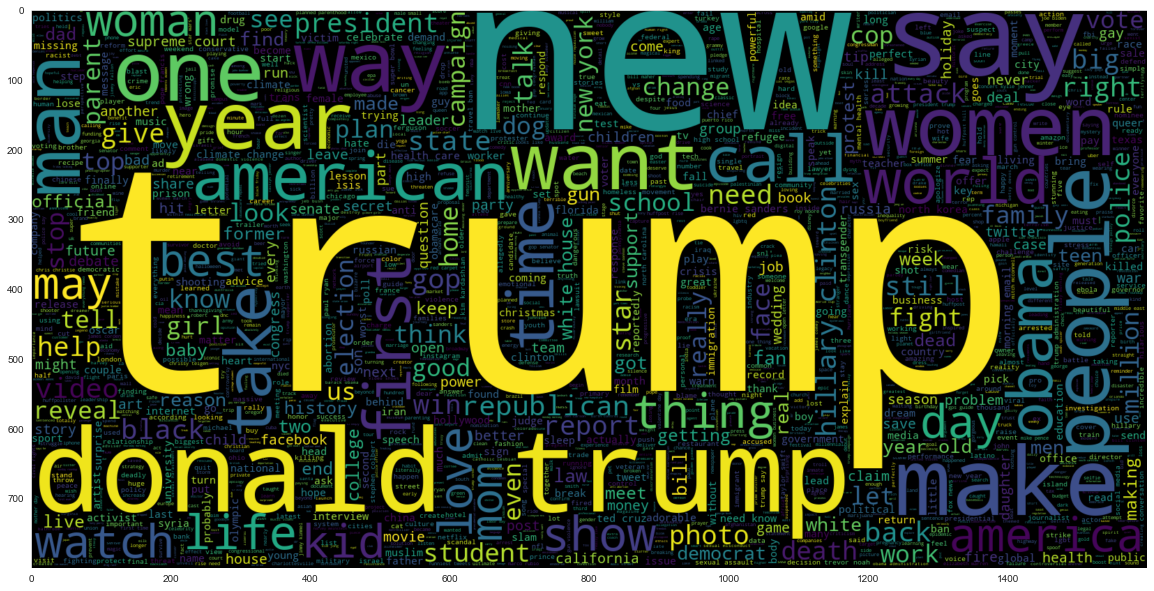

In [44]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

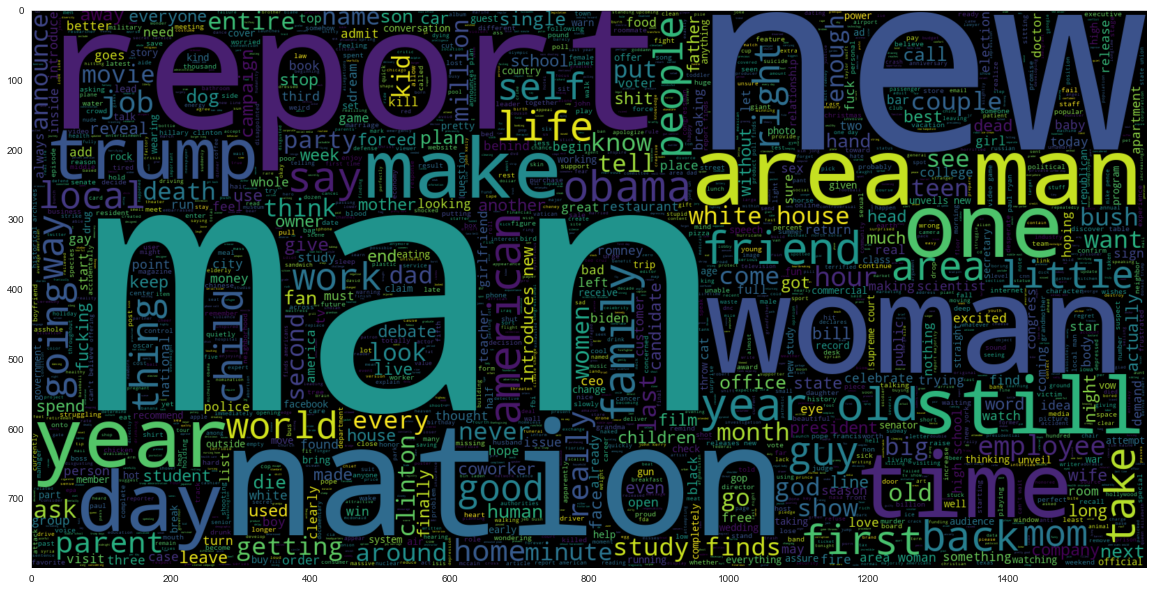

In [45]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

Frequent Occuring word in Headlines

In [53]:
all_words = df['headline'].str.split(expand=True).unstack().value_counts()

data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Viridis',
                         color = all_words.values[2:100]
                        ),text='Word counts')]

layout = go.Layout(title='Frequent Occuring words in Headlines')
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='basic-bar')

RNN and Pre-trained Glove Embeddings

In [102]:
embeddings_index = {}
f = open('glove/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [58]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [108]:
#tokenizing each question
tokenizer = Tokenizer(num_words=200000)
tokenizer.fit_on_texts(df['headline'])

df_word_sequences = tokenizer.texts_to_sequences(df['headline'])
df_padded_word_sequences = pad_sequences(df_word_sequences, maxlen=150)

word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():    
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [122]:
X = df.headline
Y = df.is_sarcastic
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [172]:
max_len = 150
max_words= 29590

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,300,input_length=max_len)(inputs)
    layer = Bidirectional(LSTM(64))(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.3)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

hist = model.fit(df_padded_word_sequences,Y,batch_size=64,epochs=10, validation_split=0.1)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 150, 300)          8877000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               186880    
_________________________________________________________________
FC1 (Dense)                  (None, 256)               33024     
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

/usr/local/Cellar/jupyterlab/2.0.1/libexec/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 24038 samples, validate on 2671 samples
Epoch 1/10
24038/24038 [==============================] - 196s 8ms/step - loss: 0.4792 - accuracy: 0.7634 - val_loss: 0.4248 - val_accuracy: 0.8031
Epoch 2/10
24038/24038 [==============================] - 255s 11ms/step - loss: 0.2898 - accuracy: 0.8792 - val_loss: 0.4285 - val_accuracy: 0.8147
Epoch 3/10
24038/24038 [==============================] - 273s 11ms/step - loss: 0.2093 - accuracy: 0.9167 - val_loss: 0.4269 - val_accuracy: 0.8177
Epoch 4/10
24038/24038 [==============================] - 223s 9ms/step - loss: 0.1531 - accuracy: 0.9416 - val_loss: 0.4598 - val_accuracy: 0.8023
Epoch 5/10
24038/24038 [==============================] - 183s 8ms/step - loss: 0.1092 - accuracy: 0.9608 - val_loss: 0.5333 - val_accuracy: 0.8076
Epoch 6/10
24038/24038 [==============================] - 186s 8ms/step - loss: 0.0741 - accuracy: 0.9738 - val_loss: 0.5709 - val_accuracy: 0.8004
Epoch 7/10
24038/24038 [==============================] - 185

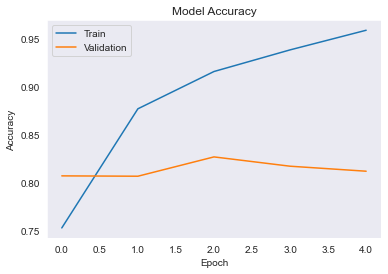

In [162]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Tf-IDF Vectorizer and XGBoost

In [163]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(df.headline,df.is_sarcastic,test_size = 0.1)

from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(token_pattern = "[a-zA-Z]{2,}",max_features=2000,ngram_range=(1,2))
train_X = vect.fit_transform(train_x)

In [173]:
from sklearn.metrics import accuracy_score
import xgboost
from xgboost import XGBClassifier

scores = []

for i in range(6,14):
    model = XGBClassifier(max_depth = i)
    model.fit(train_X,train_y)
    target = model.predict(vect.transform(test_x))
    score = accuracy_score(target,test_y)
    scores.append(score)
    print ("accuracy score: ",score," Depth: ",i)
    
#print(scores)
print("best score: ",max(scores))

accuracy score:  0.7315612130288282  Depth:  6
accuracy score:  0.7326843878697117  Depth:  7
accuracy score:  0.7416697865967802  Depth:  8
accuracy score:  0.7405466117558966  Depth:  9
accuracy score:  0.7450393111194309  Depth:  10
accuracy score:  0.7469112691875702  Depth:  11
accuracy score:  0.752527143391988  Depth:  12
accuracy score:  0.7502807937102209  Depth:  13
best score:  0.752527143391988
